<a href="https://colab.research.google.com/github/240183078-vin/My-first-v/blob/main/Final_Project.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install requests beautifulsoup4 lxml pandas


In [ ]:
import requests
from bs4 import BeautifulSoup
import json
import pandas as pd

HEADERS = {
    "User-Agent": "Mozilla/5.0 (X11; Linux x86_64) AppleWebKit/537.36 "
                  "(KHTML, like Gecko) Chrome/120.0 Safari/537.36"
}


In [ ]:
#DATA SCRAPING, DONE BY VINCENT.T

In [ ]:
URL_TEMPLATES = {
    # 1) Discount catalog
    "discounts": (
        "https://arbuz.kz/ru/almaty/discount-catalog/225443-skidki"
        "?available=0&limit=52&page={page}"
    ),

    # 2) Main food categories
    "ovoshi_frukty_zelen": (
        "https://arbuz.kz/ru/almaty/catalog/cat/225164-ovoshi_frukty_zelen"
        "?available=0&limit=52&page={page}"
    ),
    "kolbasy_i_delikatesy": (
        "https://arbuz.kz/ru/almaty/catalog/cat/225167-kolbasy_i_delikatesy"
        "?available=0&limit=52&page={page}"
    ),
    "moloko_slivki_sgush": (
        "https://arbuz.kz/ru/almaty/catalog/cat/19986-moloko_slivki_sgush_nnoe_moloko"
        "?available=0&limit=52&page={page}"
    ),
    "myaso_i_ptica": (
        "https://arbuz.kz/ru/almaty/catalog/cat/225162-myaso_i_ptica"
        "?available=0&limit=52&page={page}"
    ),
    "ryba_i_moreprodukty": (
        "https://arbuz.kz/ru/almaty/catalog/cat/225752-ryba_i_moreprodukty"
        "?available=0&limit=52&page={page}"
    ),
    "zamorozhennye_produkty": (
        "https://arbuz.kz/ru/almaty/catalog/cat/225183-zamorozhennye_produkty"
        "?available=0&limit=52&page={page}"
    ),
    "voda_i_napitki": (
        "https://arbuz.kz/ru/almaty/catalog/cat/14-voda_i_napitki"
        "?available=0&limit=52&page={page}"
    ),
    "orehi_suhofrukty_sneki": (
        "https://arbuz.kz/ru/almaty/catalog/cat/225602-orehi_suhofrukty_i_sneki"
        "?available=0&limit=52&page={page}"
    ),
    "novyi_god": (
        "https://arbuz.kz/ru/almaty/catalog/cat/224993-novyi_god"
        "?available=0&limit=52&page={page}"
    ),

    # 3) Extra categories you gave
    "eko_bio_vegan": (
        "https://arbuz.kz/ru/almaty/catalog/cat/224645-eko_bio_vegan"
        "?available=0&limit=52&page={page}"
    ),
    "hleb_i_vypechka": (
        "https://arbuz.kz/ru/almaty/catalog/cat/225165-hleb_i_vypechka"
        "?available=0&limit=52&page={page}"
    ),
    "zoo_magazin": (
        "https://arbuz.kz/ru/almaty/catalog/cat/20-zoo_magazin"
        "?available=0&limit=52&page={page}"
    ),
    "kosmetika_i_gigiena": (
        "https://arbuz.kz/ru/almaty/catalog/cat/224407-kosmetika_i_sredstva_lichnoi_gigieny"
        "?available=0&limit=52&page={page}"
    ),
    "vs_dlya_doma": (
        "https://arbuz.kz/ru/almaty/catalog/cat/16-vs_dlya_doma"
        "?available=0&limit=52&page={page}"
    ),
    "dlya_detei_i_roditelei": (
        "https://arbuz.kz/ru/almaty/catalog/cat/19-dlya_detei_i_ih_roditelei"
        "?available=0&limit=52&page={page}"
    ),
    "bakaleya": (
        "https://arbuz.kz/ru/almaty/catalog/cat/225169-bakaleya"
        "?available=0&limit=52&page={page}"
    ),
    "gotovaya_eda": (
        "https://arbuz.kz/ru/almaty/catalog/cat/225253-gotovaya_eda"
        "?available=0&limit=52&page={page}"
    ),
}


In [ ]:
def scrape_collection(url_template, collection_name, max_pages=50):
    """
    Scrape one Arbuz collection or category.
    """
    all_products = []

    for page in range(1, max_pages + 1):
        url = url_template.format(page=page)
        resp = requests.get(url, headers=HEADERS)
        if resp.status_code != 200:
            print(f"[{collection_name}] stop at page {page}, status={resp.status_code}")
            break

        soup = BeautifulSoup(resp.text, "lxml")
        cards = soup.find_all(attrs={":product": True})
        if not cards:
            print(f"[{collection_name}] no products on page {page} → stop")
            break

        for card in cards:
            product_json = card[":product"]
            product = json.loads(product_json)
            all_products.append(product)

        print(f"[{collection_name}] page {page}: {len(cards)} products")

    if not all_products:
        return pd.DataFrame()

    df = pd.json_normalize(all_products)

    # keep only needed columns
    desired_cols = ["id", "catalogName", "brandName", "name",
                    "priceActual", "pricePrevious"]
    cols = [c for c in desired_cols if c in df.columns]
    df = df[cols].copy()

    df = df.rename(columns={
        "catalogName": "category",
        "brandName": "brand",
        "priceActual": "price_raw",
        "pricePrevious": "old_price_raw",
    })

    # ensure numeric prices
    df["price_raw"] = pd.to_numeric(df["price_raw"], errors="coerce")
    df["old_price_raw"] = pd.to_numeric(df["old_price_raw"], errors="coerce")

    # if old price missing or 0 → replace with current price
    df["old_price_raw"] = df["old_price_raw"].fillna(0)
    df.loc[df["old_price_raw"] == 0, "old_price_raw"] = df["price_raw"]

    # add which collection it came from (useful later)
    df["collection"] = collection_name

    return df


In [88]:
frames = []

for name, template in URL_TEMPLATES.items():
    print(f"\n=== Scraping {name} ===")
    df_cat = scrape_collection(template, collection_name=name, max_pages=50)
    frames.append(df_cat)

# combine everything
df_all = pd.concat(frames, ignore_index=True)

# drop duplicate products by id (if column exists)
if "id" in df_all.columns:
    df_all = df_all.drop_duplicates(subset=["id"])

print("Total products:", len(df_all))
df_all.head()



=== Scraping discounts ===
[discounts] no products on page 1 → stop

=== Scraping ovoshi_frukty_zelen ===
[ovoshi_frukty_zelen] page 1: 52 products
[ovoshi_frukty_zelen] page 2: 52 products
[ovoshi_frukty_zelen] page 3: 52 products
[ovoshi_frukty_zelen] page 4: 52 products
[ovoshi_frukty_zelen] page 5: 52 products
[ovoshi_frukty_zelen] page 6: 43 products
[ovoshi_frukty_zelen] no products on page 7 → stop

=== Scraping kolbasy_i_delikatesy ===
[kolbasy_i_delikatesy] page 1: 52 products
[kolbasy_i_delikatesy] page 2: 52 products
[kolbasy_i_delikatesy] page 3: 52 products
[kolbasy_i_delikatesy] page 4: 52 products
[kolbasy_i_delikatesy] page 5: 52 products
[kolbasy_i_delikatesy] page 6: 49 products
[kolbasy_i_delikatesy] no products on page 7 → stop

=== Scraping moloko_slivki_sgush ===


/tmp/ipython-input-4118626405.py:51: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '[ 1500.    2935.    1905.     725.    1150.    2790.    1720.    1980.
   625.    1995.    1861.    2030.     850.    2525.    1855.    1750.
  3165.    1305.    3325.    3000.    3165.    2120.    2017.    2195.
  5125.    3099.    2225.    4299.    1905.    1045.     525.    2526.
  2585.    1605.    1855.    1645.    2325.    2472.    1290.    2805.
  1465.    1195.    1475.    2199.    3699.    5845.    1815.   35000.
 13030.    5370.   10255.    2685.    2672.5   2244.    4030.    2835.
  2145.    1562.    1668.    1748.    1320.    1775.    6985.    3985.
  3540.    2615.    3670.    3670.    3325.    3325.    3325.    2640.
  1145.    1065.    1145.     780.    1550.    6012.    2465.    1999.
  1999.    3190.     995.    2342.    3165.    4950.    1585.5   4875.
  2725.    2945.    2365.    3150.    3225.    1470. 

[moloko_slivki_sgush] page 1: 52 products
[moloko_slivki_sgush] page 2: 52 products
[moloko_slivki_sgush] page 3: 52 products
[moloko_slivki_sgush] page 4: 34 products
[moloko_slivki_sgush] no products on page 5 → stop

=== Scraping myaso_i_ptica ===
[myaso_i_ptica] page 1: 52 products
[myaso_i_ptica] page 2: 52 products
[myaso_i_ptica] page 3: 52 products
[myaso_i_ptica] page 4: 52 products
[myaso_i_ptica] page 5: 52 products
[myaso_i_ptica] page 6: 52 products
[myaso_i_ptica] page 7: 2 products
[myaso_i_ptica] no products on page 8 → stop

=== Scraping ryba_i_moreprodukty ===


/tmp/ipython-input-4118626405.py:51: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '[ 9570.   2730.   4320.   2965.   7518.   6075.   4550.   7785.   4199.
  7990.   5199.   6950.   9380.   8795.   7490.   9599.   3299.  13999.
  3795.    770.   2660.   5999.   5299.   8580.   8580.   7335.   8580.
  8580.  10110.   4455.   3105.   5670.   5670.   5670.   5130.   8780.
  7670.   3025.   6840.   6890.   6890.   6500.   5865.   4850.   4850.
  4550.   3510.   4550.   4850.   3640.   3510.   3250.   4290.   4290.
  4290.   4290.   4290.   4290.   3250.   4290.  11695.  11599.  11599.
 11695.  16520.  20420.  11695.   6280.  21450.  15340.  11995.   2490.
 20715.  12990.  12990.  12995.   4999.   8899.   9995.   6995.  11695.
  9690.  11999.  12990.  12990.   8550.  20245.   4399.   4599.   5690.
  8420.   2950.   2780.   5720.   5980.   5330.   5590.   4500.   4455.
  2615.   2685.   6020.   7020.   7775.   

[ryba_i_moreprodukty] page 1: 52 products
[ryba_i_moreprodukty] page 2: 52 products
[ryba_i_moreprodukty] page 3: 52 products
[ryba_i_moreprodukty] page 4: 52 products
[ryba_i_moreprodukty] page 5: 52 products
[ryba_i_moreprodukty] page 6: 3 products
[ryba_i_moreprodukty] no products on page 7 → stop

=== Scraping zamorozhennye_produkty ===


/tmp/ipython-input-4118626405.py:51: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '[  5925.   14815.   12750.   12750.    2275.    3380.    7280.     910.
   2210.     910.    2210.    4750.    5690.   12495.    4550.    5499.
  21865.   21865.   21865.    4400.    7399.    4995.   11999.   12219.
   6150.    6250.   12190.    6625.   11779.    8074.    5945.   12750.
   4665.   11019.    8125.    7490.    5000.    6125.   15000.    6280.
  13750.   10440.    7625.   10440.    3487.5  13750.    6125.    6000.
   7250.    4255.   11740.    7250.    6865.    8250.    9375.    5685.
   5685.    4918.    5465.    6226.    8244.    5082.   25000.   18599.
   3695.    2815.    4199.    3299.    2055.    3815.    5855.    7290.
   8925.    5049.    4490.    3695.    3799.    2815.    2875.    3125.
   4199.    3299.   25000.   18599.   27500.   19990.    6875.    4615.
   6625.    2760.    1910.    5370.     87

[zamorozhennye_produkty] page 1: 52 products
[zamorozhennye_produkty] page 2: 52 products
[zamorozhennye_produkty] page 3: 52 products
[zamorozhennye_produkty] page 4: 52 products
[zamorozhennye_produkty] page 5: 52 products
[zamorozhennye_produkty] page 6: 52 products
[zamorozhennye_produkty] page 7: 52 products
[zamorozhennye_produkty] page 8: 52 products
[zamorozhennye_produkty] page 9: 52 products
[zamorozhennye_produkty] page 10: 52 products
[zamorozhennye_produkty] page 11: 52 products
[zamorozhennye_produkty] page 12: 37 products
[zamorozhennye_produkty] no products on page 13 → stop

=== Scraping voda_i_napitki ===
[voda_i_napitki] page 1: 52 products
[voda_i_napitki] page 2: 52 products
[voda_i_napitki] page 3: 52 products
[voda_i_napitki] page 4: 52 products
[voda_i_napitki] page 5: 52 products
[voda_i_napitki] page 6: 52 products
[voda_i_napitki] page 7: 52 products
[voda_i_napitki] page 8: 52 products
[voda_i_napitki] page 9: 52 products
[voda_i_napitki] page 10: 52 product

id  category brand                           name  price_raw  \
0  334411  Помидоры  None              Помидор ветка, кг     1050.0   
1  334412  Помидоры  None     Помидоры розовые Китай, кг     1025.0   
2  334413  Помидоры  None              Помидор черри, кг     1750.0   
3  334415    Огурцы  None            Огурцы крокодил, кг     1250.0   
4  334417     Перец  None  Перец полугорький красный, кг     1755.0   

   old_price_raw           collection  
0         1050.0  ovoshi_frukty_zelen  
1         1025.0  ovoshi_frukty_zelen  
2         1750.0  ovoshi_frukty_zelen  
3         1250.0  ovoshi_frukty_zelen  
4         1755.0  ovoshi_frukty_zelen

In [89]:
df_final = df_all[["category", "brand", "name", "price_raw", "old_price_raw"]].copy()
df_final.head()


category brand                           name  price_raw  old_price_raw
0  Помидоры  None              Помидор ветка, кг     1050.0         1050.0
1  Помидоры  None     Помидоры розовые Китай, кг     1025.0         1025.0
2  Помидоры  None              Помидор черри, кг     1750.0         1750.0
3    Огурцы  None            Огурцы крокодил, кг     1250.0         1250.0
4     Перец  None  Перец полугорький красный, кг     1755.0         1755.0

In [130]:
from google.colab import data_table
data_table.DataTable(df_all, include_index=False, num_rows_per_page=50)


In [91]:
# SAVE CSV
df_final.to_csv("arbuz_dataset.csv", index=False)

# DOWNLOAD CSV
from google.colab import files
files.download("arbuz_dataset.csv")


In [92]:
#DATA CLEANING, DONE BY RAMAZAN

In [131]:
df_final.head(), df_final.info(), df_final.describe()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 11029 entries, 0 to 11028
Data columns (total 7 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   category          11029 non-null  object 
 1   brand             10718 non-null  object 
 2   name              11029 non-null  object 
 3   price_raw         11029 non-null  float64
 4   old_price_raw     11029 non-null  float64
 5   discount_amount   11029 non-null  float64
 6   discount_percent  11029 non-null  float64
dtypes: float64(4), object(3)
memory usage: 603.3+ KB


(   category brand                           name  price_raw  old_price_raw  \
 0  Помидоры   NaN              Помидор ветка, кг     1050.0         1050.0   
 1  Помидоры   NaN     Помидоры розовые Китай, кг     1025.0         1025.0   
 2  Помидоры   NaN              Помидор черри, кг     1750.0         1750.0   
 3    Огурцы   NaN            Огурцы крокодил, кг     1250.0         1250.0   
 4     Перец   NaN  Перец полугорький красный, кг     1755.0         1755.0   
 
    discount_amount  discount_percent  
 0              0.0               0.0  
 1              0.0               0.0  
 2              0.0               0.0  
 3              0.0               0.0  
 4              0.0               0.0  ,
 None,
            price_raw  old_price_raw  discount_amount  discount_percent
 count   11029.000000   11029.000000     11029.000000      11029.000000
 mean     2704.764761    2810.732664       105.967903          0.033756
 std      4386.511012    4522.546947       530.955130       

In [94]:
import pandas as pd

df = pd.read_csv("arbuz_dataset.csv")
df.head()


In [95]:
df.head()
df.info()
df.describe()
df.isnull().sum()
df.duplicated().sum()


In [96]:
def clean_price(x):
    if pd.isna(x):
        return 0
    return float(str(x).replace(" ", "").replace(",", "").strip())

df["price_raw"] = df["price_raw"].apply(clean_price)
df["old_price_raw"] = df["old_price_raw"].apply(clean_price)


In [97]:
df.loc[df["old_price_raw"] == 0, "old_price_raw"] = df["price_raw"]



In [98]:
df["discount_amount"] = df["old_price_raw"] - df["price_raw"]

df["discount_percent"] = (df["discount_amount"] / df["old_price_raw"]) * 100
df["discount_percent"] = df["discount_percent"].round(2)


In [99]:
df["brand"] = df["brand"].fillna("Unknown")


In [100]:
df["name"] = df["name"].fillna("Unnamed Product")


In [101]:
df = df.drop_duplicates()

df = df[(df["price_raw"] > 50) & (df["price_raw"] < 300000)]


In [102]:
df_clean = df[[
    "category", "name",
    "price_raw", "old_price_raw",
    "discount_amount", "discount_percent"
]]

df_clean.head()


In [103]:
import pandas as pd
df_final = pd.read_csv("arbuz_dataset.csv")   # or whatever name you used


In [104]:
#VISUALIZATION, DONE BY AINUR

In [105]:
df_final.columns.tolist()


In [106]:
df_final.head()
df_final.info()
df_final.describe()
df_final["category"].value_counts().head(20)



In [107]:
# ensure numeric
df_final["price_raw"] = pd.to_numeric(df_final["price_raw"], errors="coerce")
df_final["old_price_raw"] = pd.to_numeric(df_final["old_price_raw"], errors="coerce")

# if old_price_raw is 0/NaN → use price_raw
df_final["old_price_raw"] = df_final["old_price_raw"].fillna(0)
df_final.loc[df_final["old_price_raw"] == 0, "old_price_raw"] = df_final["price_raw"]

# new features
df_final["discount_amount"] = df_final["old_price_raw"] - df_final["price_raw"]
df_final["discount_percent"] = (
    df_final["discount_amount"] / df_final["old_price_raw"]
).replace([float("inf"), -float("inf")], 0).fillna(0)

df_final.head()


In [108]:
import matplotlib.pyplot as plt
import seaborn as sns

sns.set(style="whitegrid")
plt.rcParams["figure.figsize"] = (8, 5)


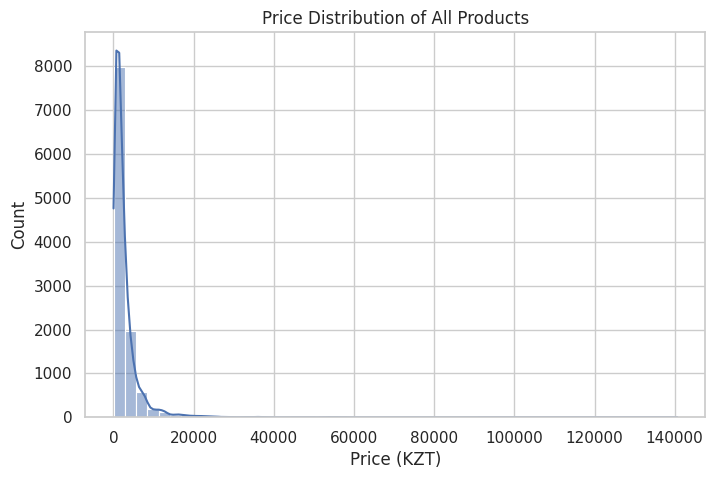

In [132]:
plt.figure()
sns.histplot(df_final["price_raw"], bins=50, kde=True)
plt.title("Price Distribution of All Products")
plt.xlabel("Price (KZT)")
plt.ylabel("Count")
plt.show()


In [ ]:
top_cats = df_final["category"].value_counts().head(10)

plt.figure()
sns.barplot(x=top_cats.values, y=top_cats.index)
plt.title("Top 10 Categories by Number of Products")
plt.xlabel("Number of products")
plt.ylabel("Category")
plt.show()


In [ ]:
top8 = df_final["category"].value_counts().head(8).index
subset = df_final[df_final["category"].isin(top8)]

plt.figure(figsize=(10, 6))
sns.boxplot(data=subset, x="category", y="price_raw")
plt.xticks(rotation=45, ha="right")
plt.title("Price Distribution by Category (Top 8)")
plt.xlabel("Category")
plt.ylabel("Price (KZT)")
plt.show()


In [ ]:
avg_price_cat = (
    df_final.groupby("category")["price_raw"]
            .mean()
            .sort_values(ascending=False)
            .head(10)
)

plt.figure()
sns.barplot(x=avg_price_cat.values, y=avg_price_cat.index)
plt.title("Top 10 Categories by Average Price")
plt.xlabel("Average price (KZT)")
plt.ylabel("Category")
plt.show()


In [ ]:
plt.figure()
sns.histplot(df_final["discount_percent"], bins=40, kde=True)
plt.title("Discount Percentage Distribution")
plt.xlabel("Discount (%)")
plt.ylabel("Count")
plt.show()


In [ ]:
plt.figure()
sns.scatterplot(
    data=df_final.sample(min(3000, len(df_final))),  # sample to avoid overplotting
    x="price_raw",
    y="discount_percent",
    alpha=0.4
)
plt.title("Price vs Discount Percentage")
plt.xlabel("Price (KZT)")
plt.ylabel("Discount (%)")
plt.show()


In [ ]:
df_final.sort_values("price_raw", ascending=False)[
    ["category", "brand", "name", "price_raw"]
].head(10)


In [ ]:
df_final.sort_values("price_raw", ascending=True)[
    ["category", "brand", "name", "price_raw"]
].head(10)


In [ ]:
cat_counts = df_final["category"].value_counts()
cat_counts.head(15)


In [ ]:
avg_price = df_final.groupby("category")["price_raw"].mean().sort_values(ascending=False)
avg_price.head(10)



In [ ]:
avg_disc = (
    df_final.groupby("category")["discount_percent"]
            .mean()
            .sort_values(ascending=False)
)
avg_disc.head(10)


In [ ]:
corr_price_discount = df_final["price_raw"].corr(df_final["discount_percent"])
corr_price_discount


In [ ]:
corr_old_disc_amount = df_final["old_price_raw"].corr(df_final["discount_amount"])
corr_old_disc_amount


In [ ]:
global_disc_mean = df_final["discount_percent"].mean()

disc_by_cat = (
    df_final.groupby("category")["discount_percent"]
            .mean()
            .sort_values(ascending=False)
)

global_disc_mean, disc_by_cat.head(10), disc_by_cat.tail(10)


In [129]:
cat = "Помидоры"  # change to any category present in your data
(
    df_final[df_final["category"] == cat]["brand"]
        .value_counts()
        .head(10)
)


brand
NacAgro                3
Ayakaz                 1
Tausugur agro          1
Be Fresh Produce BV    1
Name: count, dtype: int64